# Volatility-Driven Buy-Write Strategy on S&P 500 Stocks  
### A Backtest and Analysis

**Eric Kasper**  
**CSCI-E278: Quantitative Finance**

---

In this project, I develop and evaluate an **algorithmic buy-write strategy** (also known as a covered call strategy) designed to capitalize on periods of elevated volatility in individual **S&P 500** stocks. The strategy involves initiating stock positions and simultaneously selling short-term options to generate premium income during volatility spikes.

Stock selection from the **S&P 500** is based on analysis of individual stock volatilities. The portfolio is managed dynamically over time, with options sold on selected stocks and positions adjusted based on assignment and expiry outcomes. Trades are equally sized using a fixed notional per position, and fractional shares are allowed to simplify simulation. The strategy focuses on harvesting volatility-driven option premiums while controlling exposure.

To evaluate performance, I compare the strategy against both the **S&P 500** index and a portfolio of randomly selected stocks, providing context for absolute and relative performance. Key metrics include **cumulative returns**, **Sharpe ratios**, and **drawdowns**, with additional risk-adjusted measures such as the **Sortino ratio** to better capture downside risk. Visual comparisons are used to assess relative performance over time.

The final submission will include both a PDF version of this notebook for presentation and grading purposes, and a working copy of the notebook that requires the associated `.csv` data files and `.py` source code. The working version is structured for reproducibility and modular development, using external scripts to manage simulation logic and analysis.

This project reflects my interest in quantitative strategies, portfolio construction, and performance analytics, and aligns closely with the objectives of **CSCI-E278: Quantitative Finance**.


## I. Strategy Overview

### 1. Market Philosophy: Volatility as an Expression of Panic

This strategy is grounded in the belief that **investors panic**, and that this behavior is **reflected in volatility**. During times of stress, volatility indices such as the **VIX** tend to spike in response to uncertainty or negative news. These spikes are often short-lived and excessive, suggesting an opportunity to capture returns through **mean reversion**.

Having observed several market events—ranging from earnings shocks to systemic dislocations—it is clear that volatility is not just a technical metric, but an emotional one. The goal of this strategy is to systematically detect and monetize those overreactions.

![VIX History](vix_chart.png)

---

### 2. The Mechanics of Buy-Write and Sell-Write Strategies

A **buy-write** strategy consists of purchasing a stock while simultaneously selling a call option against it. This approach generates premium income while capping upside beyond the strike price. It is most effective when the underlying asset trades in a range or exhibits modest upward momentum.

The counterpart is the **sell-write**, which involves selling a put option and taking a short position in the same security. This expresses a mildly bearish stance and may result in the seller being put the stock on a decline which would cover the short.

![Hockey Sticks](hockey_sticks.png)

Both strategies aim to harvest option premium and monetize elevated implied volatility.

---

### 3. Portfolio Design: Diversification Beyond the Ticker

Individual stocks within the same industry or sector often behave similarly. This correlation can lead to unintended concentration risks if not properly managed.

To mitigate this, the strategy imposes sector limits by capping the number of holdings from each industry group. This ensures exposure to a broad set of underlying drivers and helps improve risk-adjusted returns.

![Correlation](correlation.png)

By diversifying across sectors, the strategy reduces the chance that a single thematic shock unduly impacts overall performance.

---

### 4. Volatility Breakout Threshold: Signal Generation

Stock selection is driven by a **volatility breakout threshold**. Specifically, the strategy measures short-term volatility and compares it to each stock’s historical baseline to identify unusual price activity.

The process is as follows:

- Compute 30-day realized volatility for each stock.
- Calculate a z-score relative to the trailing 60-day mean and standard deviation of volatility.
- Rank all stocks by this breakout score, denoted **χ (chi)**.
- Select the top N tickers for further analysis.

This method highlights names experiencing statistically significant changes in volatility, which often precede meaningful price movements.

---

### 5. Momentum Thresholding: The Bullishness Threshold θ

Once a breakout has been identified, the strategy evaluates whether to take a long or short position using a **momentum signal**. This decision is governed by a configurable **bullishness threshold**, denoted **θ (theta)**.

$$
\theta = -1 \times \alpha \times \tau
$$

Where:

- $\alpha$ is a constant (+1 or -1) based on strategy mode,  
- $\tau$ reflects directional conviction on a scale from 0 (neutral) to 1 (fully bullish).

If a stock's momentum score exceeds θ, a **buy-write** is initiated. If not, a **sell-write** is used.

This approach allows the strategy to respond flexibly to market context, applying a tilt without rigidly enforcing directional bias.

---

### 6. Simplifying Assumptions and Academic Framing

The analysis operates under a set of simplifying assumptions that enable clear academic evaluation:

- Positions are **equally weighted** by notional size.
- **Fractional shares** are permitted for allocation precision.
- There are no **transaction costs**, commissions, slippage, or spreads.
- A wide range of strikes and maturities is assumed to be available in the **options market** at all times.
- **Historical volatility** is used as a proxy for implied volatility.

These assumptions do not reflect actual market conditions but serve to isolate the strategy’s structural logic. For live deployment, further enhancements would be necessary to account for liquidity, execution costs, and the limits of available instruments.

---


## II. Data, Methodology & Performance Evaluation

#### Data Sources

This experiment draws upon the following publicly available datasets:
- **Stock Prices**: Daily adjusted close prices from Yahoo Finance for S&P 500 constituents.  
- **Constituent List**: The list of current S&P 500 members was scraped from Wikipedia at the outset of the experiment.  
- **Sector Classification**: Sector tags for each ticker were obtained from the same Wikipedia source and cross-validated with Yahoo Finance metadata.

#### Methodology

The simulation proceeds through time in discrete intervals of `t` trading days (typically equal to the option holding window, denoted **𝜏**). At each decision point:

1. Each position either:  
   - **Expires out of the money (OTM)**, in which case the stock remains in the portfolio, or  
   - **Is assigned** (i.e., the option is exercised), and the position is exited.

2. The number of active bets, `N`, is fixed across the simulation. Each position is equally weighted. For example, with 5 positions at $10,000 each, total capital outlay (**𝜅**) is $50,000.

3. After each **𝜏**-day interval, exited positions are replaced using the stock selection process described in the *Strategy Overview* section. Positions that are not assigned remain in the portfolio.

#### Performance Evaluation

Performance is assessed at each decision point based on:
- Realized premiums from expired options (whether assigned or unassigned)  
- Realized **capital gains** from assigned positions  
- Unrealized gains or losses on held stock positions

Over the full simulation horizon, we compute:
- **Total P&L**, expressed as a percentage of **𝜅**  
- **Sharpe Ratio**, calculated using the mean and standard deviation of rolling window returns, annualized

#### Hyperparameter Tuning

The model includes the following tunable hyperparameters:

| Symbol           | Description                                         |
|------------------|-----------------------------------------------------|
| `N`              | Number of active positions                          |
| **𝜏**            | Option holding period (days)                        |
| **𝜆**            | Sector cap: max positions per sector                |
| **ρ̃**            | Correlation threshold between positions             |
| **𝜔**            | Percent out-of-the-money for strike selection       |
| **𝜏ₛ**           | Volatility lookback window                          |
| **𝜃**            | Bullishness filter (see Strategy Overview)          |
| **𝛼**            | Option-writing aggressiveness (see Strategy Overview) |

For this initial version, we tune a reduced set of parameters:  
**`N`**, **ρ̃**, **𝜆**, **𝜔**, and **𝜃**


## III. Strategy Workflow Overview

This section outlines the full end-to-end architecture of the Buy-Write simulation process, as visualized in the diagram above. It includes all components from data ingestion to trade simulation and hyperparameter optimization.

![simulator flow](simulator_flow.png)


### A. BuyWrite Notebook (`.ipynb`)
This notebook orchestrates the simulation process and controls the execution flow.

- Begins with a **batch downloader** that pulls stock symbols from **Wikipedia** and historical price data from **Yahoo Finance**.
- All data is saved locally to the file system under the `data/` directory.
- It then **calls the `BuyWritePortfolioSimulator`** with parameters defined by the user or optimizer.

---

### B. Create Volatility Summary (`py/createVolDf.py`)
This script processes the raw data and computes the analytics used for trade selection.

- Calculates **log returns**, **rolling volatility**, and **Z-scores** for each ticker.
- Outputs a **volatility summary DataFrame** used by the simulator during screening and ranking.

---

### C. BuyWrite Portfolio Simulator (`BuyWritePortfolioSimulator.py`)

The core simulation engine. It manages the simulation calendar and portfolio state.

1. **Generates the calendar** of simulation dates based on expiry spacing.
2. **Roll or Replace logic**:  
   - Determines whether each position has been assigned or expired.  
   - For unfilled slots, it screens the universe using Z-score breakouts, momentum filters, correlation constraints, and sector limits.  
   - All of this is handled by internal helper methods.
3. **Enters new positions** via `Simulate BuyWrite`.
4. **Logs trade-level output** and writes summary results to the file system.

---

### D. Simulate BuyWrite (Function)
Handles simulation of a **single buy-write trade**.

- Uses **Black-Scholes models** to estimate call and put premiums.
- Simulates assignment, expiration, and calculates realized **P&L**.
- Returns results to the simulator class for logging.

---

### E. Optimizer (`.py`)
Performs hyperparameter optimization to maximize strategy performance.

- Instantiates the simulator across a grid (or evolutionary search) of parameter combinations.
- Evaluates objective functions such as **% profit** or **Sharpe ratio**.
- Logs the **best configuration** and its performance.


## IV. Results and Analysis

### Library Imports
To streamline the notebook and encourage modular code, all necessary packages are imported via a centralized Python script (`imports.py`). This supports clean separation of logic and ensures reproducibility across notebooks using the same environment.

In [13]:
%run ../utils/imports.py
%matplotlib inline
import sys
from pathlib import Path

# Notebook is in FinalProject/notebooks/
# This adds FinalProject/ to the path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))


In [14]:
# Pull table from Wikipedia
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
tables = pd.read_html(url)

# The first table contains the S&P 500 constituents
sp500_table = tables[0]

# Extract the 'Symbol' column
sp500_tickers = sp500_table['Symbol'].tolist()

# Some symbols have dots instead of dashes (e.g., BRK.B should be BRK-B for Yahoo)
sp500_tickers = [ticker.replace('.', '-') for ticker in sp500_tickers]

# Print first 10 tickers to check
print(f"First 10 tickers: {sp500_tickers[:10]}")

# Save to CSV (optional but recommended)
ticker_list_path = "../data/sp500_tickers.csv"
pd.DataFrame(sp500_tickers, columns=["Ticker"]).to_csv(ticker_list_path, index=False)

print(f"Saved {len(sp500_tickers)} tickers to {ticker_list_path}")

First 10 tickers: ['MMM', 'AOS', 'ABT', 'ABBV', 'ACN', 'ADBE', 'AMD', 'AES', 'AFL', 'A']
Saved 503 tickers to ../data/sp500_tickers.csv


### Batch Download of S&P 500 Stock Prices and Sector Data

This section downloads historical stock prices and sector classifications for S&P 500 companies from Yahoo Finance. The logic is encapsulated in a Python utility script (`sp500_loader.py`) to ensure modularity, reuse, and clarity.

Key features:
- Tickers are sourced from `sp500_tickers.csv`.
- Price data is saved as individual CSVs in `../data/stock_prices/`.
- Sector mappings are saved to `sector_map.json`.
- Missing tickers are logged to `missing_tickers.txt`.
- A summary of tickers processed is returned and printed.
- Verbose logs are written to `../logs/download.log`, with the last few lines displayed below.

If the `clear_existing` flag is set to `True`, the target directory is cleared before downloading begins. This is defaulted to `False` for safety.


In [15]:
from utils.sp500_loader import download_sp500_with_sectors

summary = download_sp500_with_sectors(start_date="2015-01-01", end_date="2025-05-13",clear_existing=False)

print("📊 Download Summary:")
for k, v in summary.items():
    print(f"  {k.replace('_', ' ').capitalize()}: {v}")

📦 Pulling batch 1 of 26 (20 tickers)
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 2 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 3 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 4 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

📦 Pulling batch 5 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 6 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

📦 Pulling batch 7 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 8 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 9 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 10 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

📦 Pulling batch 11 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 12 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

📦 Pulling batch 13 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 14 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 15 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

📦 Pulling batch 16 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[*****                 10%                       ]  2 of 20 completed

📦 Pulling batch 17 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 18 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

📦 Pulling batch 19 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 20 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

📦 Pulling batch 21 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 22 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

📦 Pulling batch 23 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 24 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed
[                       0%                       ]

📦 Pulling batch 25 of 26 (20 tickers)


[*********************100%***********************]  20 of 20 completed


📦 Pulling batch 26 of 26 (3 tickers)


[*********************100%***********************]  3 of 3 completed


📊 Download Summary:
  Tickers total: 503
  Tickers saved: 503
  Tickers skipped: 0
  Sector missing: 0
  Status: complete


### Volatility Summary Calculation

This step computes historical volatility metrics for each stock in the dataset.

- **Daily log returns** are calculated from close prices.
- **Rolling volatility** is computed using a 30-day lookback window, annualized.
- For each stock, a **z-score of volatility** is computed to identify relative spikes or drops in volatility over a 60-day trailing window.
- The result is saved to `volatility_summary.csv`, which is later used for volatility-based screening in the strategy.

The computation is modularized in the `createVolDf()` function stored in `py/createVolDf.py`.


In [16]:
from py.createVolDf import createVolDf

# Add the project root to sys.path
project_root = Path().resolve().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

# Run the volatility analytics calculation
createVolDf()

# Load and display head of the output
vol_df = pd.read_csv("../data/volatility_summary.csv", parse_dates=["Date"])
print(f"Shape of file: {vol_df.shape}")
print(f"NaNs:\n{vol_df.isna().sum()}")
nvda_df = vol_df[vol_df["Ticker"] == "NVDA"]
display(nvda_df.sort_values("Date", ascending=False).head())

✅ Saved volatility summary with breakout scores.
Shape of file: (1258656, 4)
NaNs:
Date              0
RollingVol        0
Ticker            0
Vol_ZScore    29677
dtype: int64


,Date,RollingVol,Ticker,Vol_ZScore
863901,2025-05-12,0.760517,NVDA,0.441882
863900,2025-05-09,0.747915,NVDA,0.285880
863899,2025-05-08,0.750396,NVDA,0.313373
863898,2025-05-07,0.770346,NVDA,0.554817
863897,2025-05-06,0.764597,NVDA,0.486562


### Volatility Analysis

#### Volatility Distribution

The charts below provide a 2×2 summary of the current volatility regime across the S&P 500 universe. The top row focuses on 30-day rolling annualized volatility, while the bottom row evaluates volatility Z-scores, which capture deviations from each stock’s own trailing history.

- Top Left: Histogram of the latest 30-day rolling annualized volatility. Most stocks fall between 30% and 60%, with a long right tail indicating a handful of highly volatile names.
- Top Right: Boxplot of the same data, illustrating moderate skew and a limited number of high-volatility outliers.
- Bottom Left: Histogram of volatility Z-scores, highlighting stocks experiencing statistically significant breakouts from their historical norms.
- Bottom Right: Boxplot of Z-scores, showing a wide spread and long-tailed behavior.

These charts help assess both absolute and relative volatility conditions. Many stocks exhibit elevated but not extreme volatility. A smaller subset shows Z-scores greater than 2.5, signaling abnormal volatility surges that may indicate trading opportunities.

We use both raw volatility and Z-scores as complementary signals in the screening process. While raw volatility identifies persistently active names, Z-scores are effective for detecting regime shifts or potential breakouts. Tracking this distribution through time also offers insight into broader market volatility dynamics.


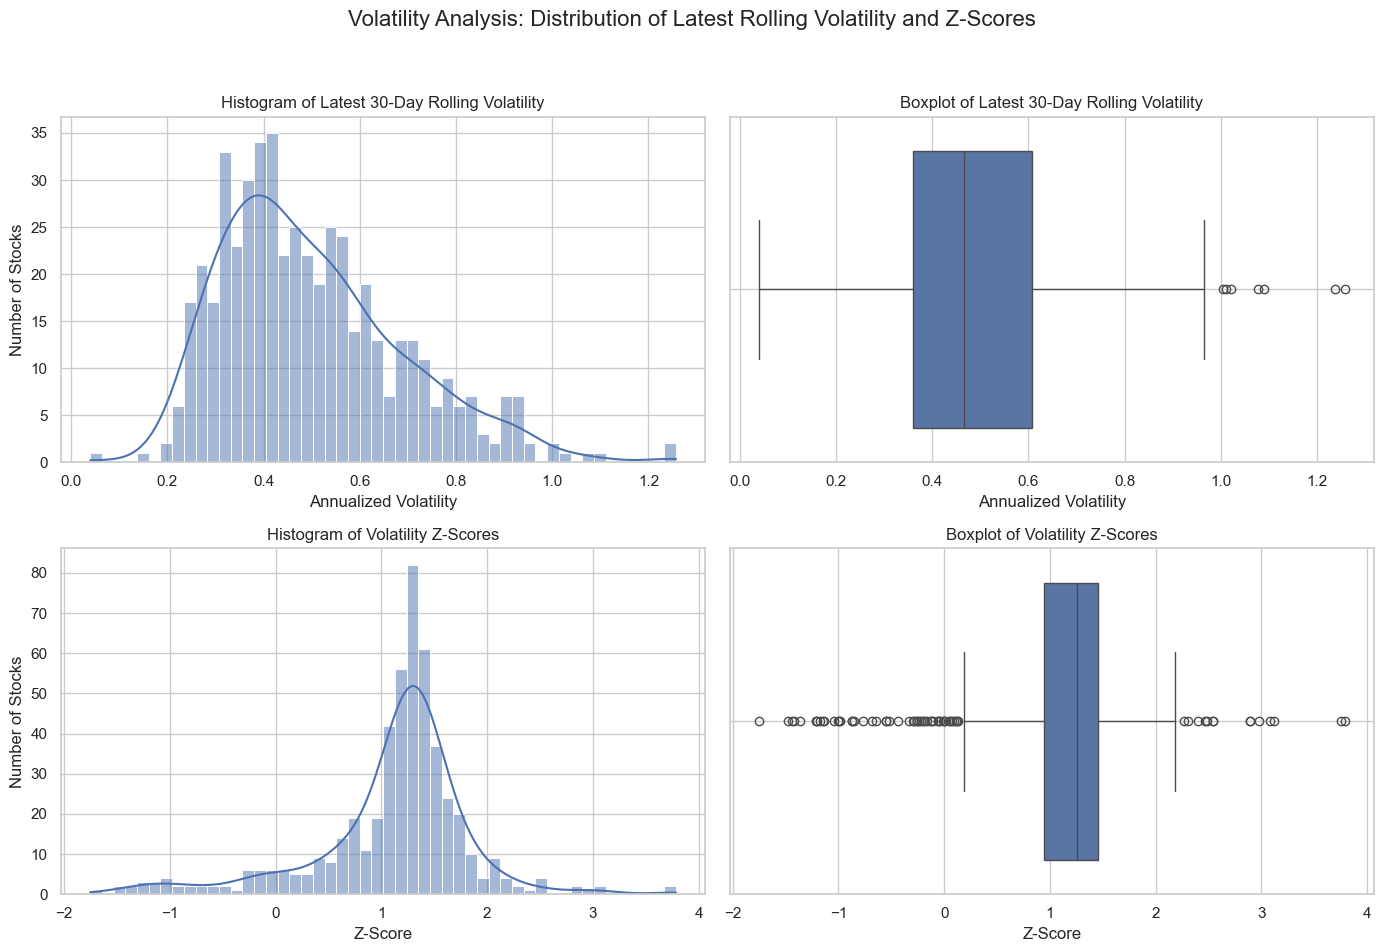

In [17]:

# Ensure the latest observation per ticker
latest_vol = vol_df.sort_values("Date").groupby("Ticker").tail(1)

# Create the 2x2 subplot grid
fig, axs = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle("Volatility Analysis: Distribution of Latest Rolling Volatility and Z-Scores", fontsize=16)

# Top-left: Histogram of RollingVol
sns.histplot(latest_vol["RollingVol"], bins=50, kde=True, ax=axs[0, 0])
axs[0, 0].set_title("Histogram of Latest 30-Day Rolling Volatility")
axs[0, 0].set_xlabel("Annualized Volatility")
axs[0, 0].set_ylabel("Number of Stocks")
axs[0, 0].grid(True)

# Top-right: Boxplot of RollingVol
sns.boxplot(x=latest_vol["RollingVol"], ax=axs[0, 1])
axs[0, 1].set_title("Boxplot of Latest 30-Day Rolling Volatility")
axs[0, 1].set_xlabel("Annualized Volatility")
axs[0, 1].grid(True)

# Bottom-left: Histogram of Vol_ZScore
sns.histplot(latest_vol["Vol_ZScore"].dropna(), bins=50, kde=True, ax=axs[1, 0])
axs[1, 0].set_title("Histogram of Volatility Z-Scores")
axs[1, 0].set_xlabel("Z-Score")
axs[1, 0].set_ylabel("Number of Stocks")
axs[1, 0].grid(True)

# Bottom-right: Boxplot of Vol_ZScore
sns.boxplot(x=latest_vol["Vol_ZScore"].dropna(), ax=axs[1, 1])
axs[1, 1].set_title("Boxplot of Volatility Z-Scores")
axs[1, 1].set_xlabel("Z-Score")
axs[1, 1].grid(True)

# Adjust spacing
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


#### Volatility Snapshot: Top Stocks by Level and Breakout

The charts below summarize the current volatility landscape across the S&P 500, using both absolute levels and relative changes.

- Top Left: The top 25 stocks ranked by 30-day rolling annualized volatility. These are persistently volatile names that tend to offer larger option premiums, but not necessarily timing signals.
- Bottom Left: The top 25 stocks ranked by volatility Z-score. These represent stocks experiencing statistically significant surges in volatility relative to their own recent history.
- Top Right: Historical volatility trends for the top 5 tickers by absolute level. These stocks remain volatile over time but do not typically exhibit sharp regime shifts.
- Bottom Right: Z-score trends for the top 5 relative breakout names. This panel clearly demonstrates that volatility tends to mean-revert—spikes are followed by normalization, often within a short time frame.

This last chart is central to our approach. The recurring pattern of volatility spikes and reversion suggests that volatility is not only measurable, but predictable. By systematically ranking the universe on Z-score, we can identify candidates that have recently experienced a volatility surge and are statistically likely to revert.

Looking forward, the stock selection algorithm will exploit this feature of volatility. Each rebalance period, we will screen the universe for names exhibiting the strongest relative volatility breakouts. These names will serve as input to the strategy's trade construction logic, with the expectation that we are capturing stocks at or near volatility inflection points.


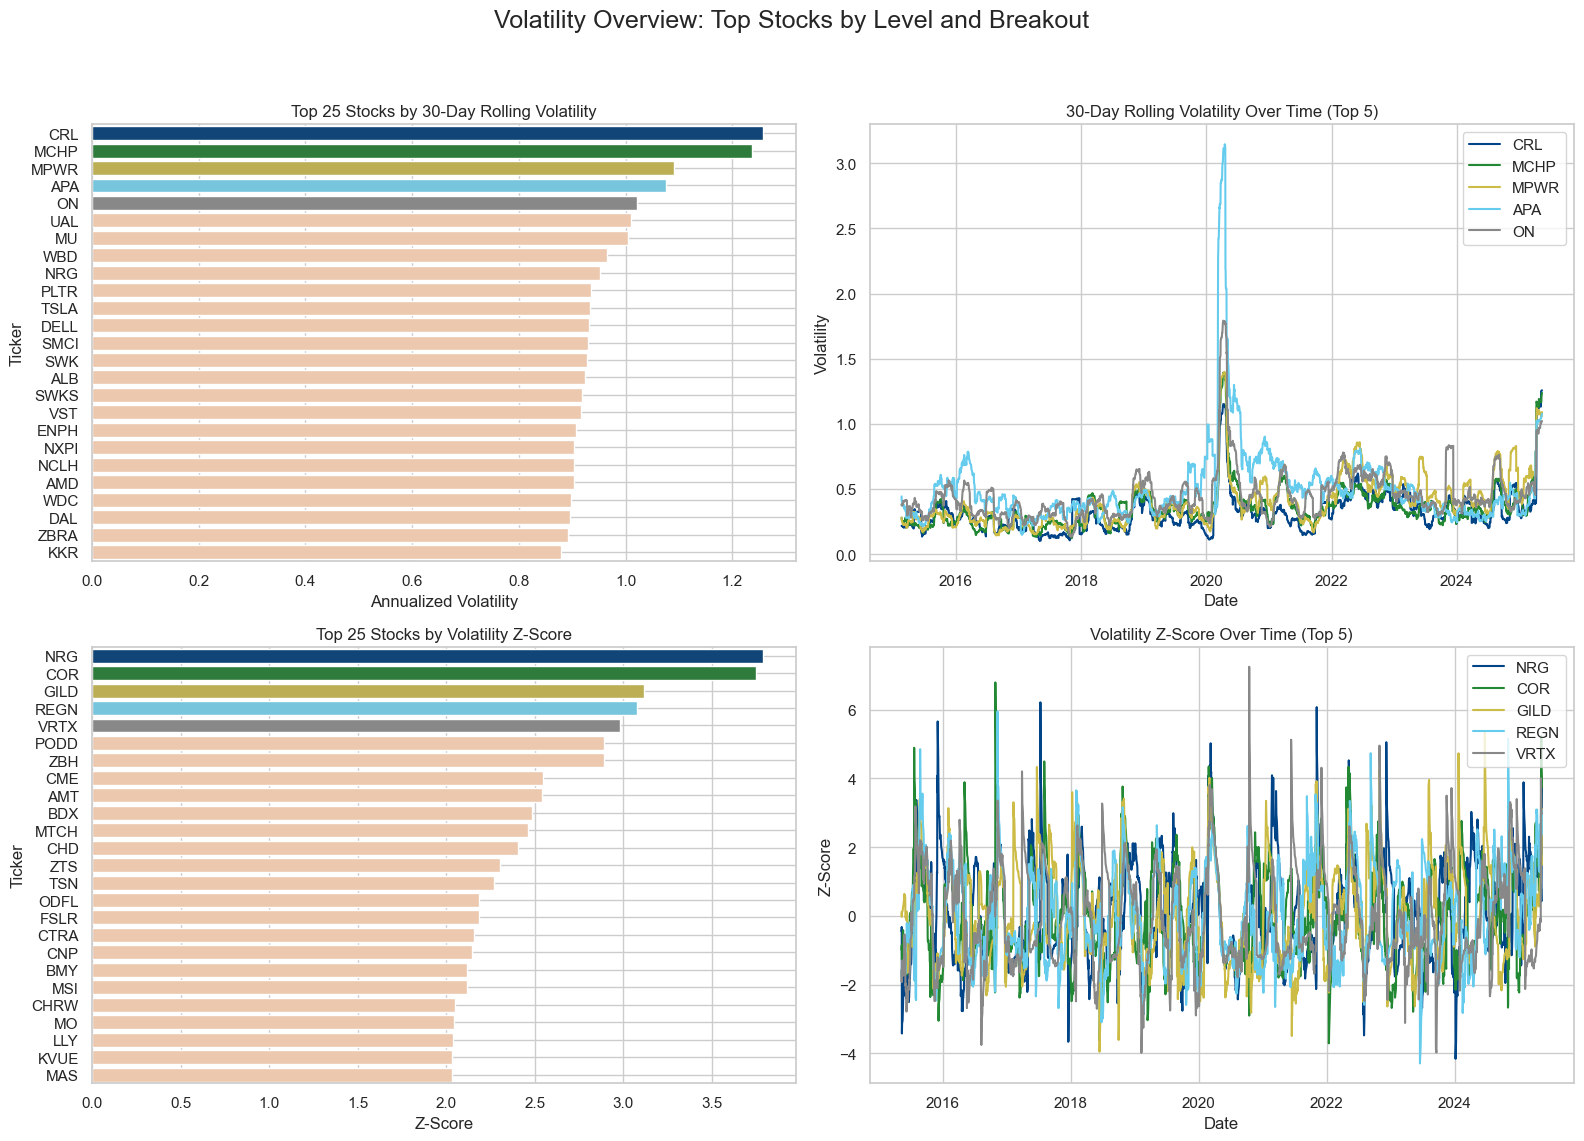

In [18]:

# Ensure most recent observation per ticker
latest_vol = vol_df.sort_values("Date").groupby("Ticker").tail(1)

# Top 25 by RollingVol and Vol_ZScore
top_25_vol = latest_vol.sort_values("RollingVol", ascending=False).head(25)
top_25_zscore = latest_vol.sort_values("Vol_ZScore", ascending=False).head(25)

# Separate top 5 tickers
top_5_vol_tickers = top_25_vol["Ticker"].head(5).tolist()
top_5_zscore_tickers = top_25_zscore["Ticker"].head(5).tolist()

# Use strong colors
# Custom muted-but-distinct palette
custom_palette = ["#004488", "#228833", "#CCBB44", "#66CCEE", "#888888"]
highlight_vol_colors = custom_palette[:len(top_5_vol_tickers)]
highlight_zscore_colors = custom_palette[:len(top_5_zscore_tickers)]
dim_color = "#f7c6a3"

# Barplot palettes with dimmed background for non-top-5
bar_palette_vol = {
    t: highlight_vol_colors[top_5_vol_tickers.index(t)] if t in top_5_vol_tickers else dim_color
    for t in top_25_vol["Ticker"]
}
bar_palette_z = {
    t: highlight_zscore_colors[top_5_zscore_tickers.index(t)] if t in top_5_zscore_tickers else dim_color
    for t in top_25_zscore["Ticker"]
}

# === Plot setup ===
fig, axs = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle("Volatility Overview: Top Stocks by Level and Breakout", fontsize=18)

# --- Top-left: Barplot of RollingVol ---
sns.barplot(
    data=top_25_vol,
    x="RollingVol",
    y="Ticker",
    hue="Ticker",
    palette=bar_palette_vol,
    ax=axs[0, 0],
    legend=False
)
axs[0, 0].set_title("Top 25 Stocks by 30-Day Rolling Volatility")
axs[0, 0].set_xlabel("Annualized Volatility")
axs[0, 0].set_ylabel("Ticker")
axs[0, 0].grid(True)

# --- Bottom-left: Barplot of Vol_ZScore ---
sns.barplot(
    data=top_25_zscore,
    x="Vol_ZScore",
    y="Ticker",
    hue="Ticker",
    palette=bar_palette_z,
    ax=axs[1, 0],
    legend=False
)
axs[1, 0].set_title("Top 25 Stocks by Volatility Z-Score")
axs[1, 0].set_xlabel("Z-Score")
axs[1, 0].set_ylabel("Ticker")
axs[1, 0].grid(True)

# --- Top-right: Line plot of RollingVol for top 5 (bold colors) ---
for i, ticker in enumerate(top_5_vol_tickers):
    df_plot = vol_df[vol_df["Ticker"] == ticker]
    axs[0, 1].plot(df_plot["Date"], df_plot["RollingVol"], label=ticker, color=highlight_vol_colors[i])

axs[0, 1].set_title("30-Day Rolling Volatility Over Time (Top 5)")
axs[0, 1].set_xlabel("Date")
axs[0, 1].set_ylabel("Volatility")
axs[0, 1].grid(True)
axs[0, 1].legend()

# --- Bottom-right: Line plot of Vol_ZScore for top 5 (bold colors) ---
for i, ticker in enumerate(top_5_zscore_tickers):
    df_plot = vol_df[vol_df["Ticker"] == ticker]
    axs[1, 1].plot(df_plot["Date"], df_plot["Vol_ZScore"], label=ticker, color=highlight_zscore_colors[i])

axs[1, 1].set_title("Volatility Z-Score Over Time (Top 5)")
axs[1, 1].set_xlabel("Date")
axs[1, 1].set_ylabel("Z-Score")
axs[1, 1].grid(True)
axs[1, 1].legend()

# Layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

### Strategy Simulation

#### Initial Run

The simulation below provides an initial illustration of how the BuyWritePortfolioSimulator operates. The goal at this stage is not to optimize parameters, but to validate the mechanics and generate representative outputs.

This implementation traverses the precomputed volatility summary DataFrame over time. At each decision point (roughly monthly), the strategy:

- Screens the universe using volatility Z-scores ("breakout" mode).
- Selects up to five stocks with the strongest positive breakouts.
- Limits sector concentration to three unique sectors.
- Filters out stocks that are highly correlated with each other (threshold: 0.85).
- Allocates $10,000 per position using fractional share sizing.
- Sells a 21-day call option on each position with a fixed expiry assumption.

All parameters are configurable and several will be tuned in subsequent sections. The current run uses placeholder values chosen for clarity and speed.

The output below includes execution logs from the simulator and summary statistics of the portfolio’s behavior over the backtest period.


In [30]:

from BuyWritePortfolioSimulator import BuyWritePortfolioSimulator
from build_price_df import build_price_df

# Load pre-calculated volatility summary
vol_summary_df = pd.read_csv("../data/volatility_summary.csv", parse_dates=["Date"])

# Preload all price data
price_dir = "../data/stock_prices"
price_df = build_price_df(price_dir)

# Create simulator instance
simulator = BuyWritePortfolioSimulator(
    vol_summary_df=vol_summary_df,
    price_dir=price_dir,
    notional_per_trade=10000,
    num_positions=5,
    option_days=21,
    sector_limit=3,
    correlation_threshold=0.85,
    screen_mode='breakout',
    theta=0.5,
    alpha=1.0,
    vol_zscore_threshold=0,
    price_df=price_df,
    debug=True
)

# Run the simulation
portfolio_results = simulator.run()

📂 Loading price data from ../data/stock_prices
📂 Complete
🚦 Starting simulation...
🚀 Starting simulation on 2015-05-12 (breakout mode)
SCREENING:  2015-05-12 00:00:00
📈 Entering NWS on 2015-05-12 (Dir=long, Corr=None)
📈 Entering IP on 2015-05-12 (Dir=long, Corr=0.7605042704374941)
📈 Entering CNC on 2015-05-12 (Dir=long, Corr=0.5389753662798139)
📈 Entering YUM on 2015-05-12 (Dir=long, Corr=0.8231478304910559)
📈 Entering WYNN on 2015-05-12 (Dir=long, Corr=0.20699845974948475)
SCREENING:  2015-06-11 00:00:00
📈 Entering NWS on 2015-06-11 (Dir=long, Corr=1.0)
📈 Entering IP on 2015-06-11 (Dir=long, Corr=1.0)
📈 Entering YUM on 2015-06-11 (Dir=long, Corr=1.0)
📈 Entering WYNN on 2015-06-11 (Dir=long, Corr=1.0)
📈 Entering BAX on 2015-06-11 (Dir=long, Corr=0.27845591853768586)

🔄 Processing expiry: 2015-06-11
SCREENING:  2015-07-13 00:00:00
📈 Entering NWS on 2015-07-13 (Dir=long, Corr=1.0)
📈 Entering IP on 2015-07-13 (Dir=long, Corr=1.0)
📈 Entering YUM on 2015-07-13 (Dir=long, Corr=1.0)
📈 Enterin

KeyboardInterrupt: 

### Stock Selection (Interpreting the Buy-Write Execution Log)

The simulator generates a detailed execution log that captures the portfolio evolution at each expiry date. Each block corresponds to a single 21-day holding period, during which the portfolio either maintains, rolls, or replaces positions.

Below are the first few rebalancing events from the log:

- **2015-06-11**: The portfolio exits two positions (NWS and WYNN) that were called away and replaces them with new entries (BAX and CPAY). Other names (IP, CNC, YUM) are rolled forward. A $912 profit is recognized for the period, and the sector mix shifts modestly.

- **2015-07-13**: IP is called away, and four positions are rolled forward. No new names are added, suggesting that the portfolio remains below the position limit due to sector or correlation constraints. PnL is lower this cycle ($424), reflecting a quieter expiry.

- **2015-08-11**: Two positions are called away (YUM, BAX), and three new ones enter: ZBRA, DXCM, and MOS. The algorithm adapts to changing volatility breakouts while maintaining diversification. Profit increases significantly to $1,415.

- **2015-09-10**: Another reshuffle, with CNC and MOS exiting. PM and REGN are introduced, reflecting fresh Z-score breakouts. Four positions are retained or rolled. This is the most profitable period so far with $1,858 recognized.

These early cycles illustrate how the algorithm selects and rotates stocks based on volatility breakout signals while enforcing portfolio constraints (sector limits, correlation thresholds, and position caps). The log also tracks recognized profits and the sector exposure deltas over time.

This log provides transparency into the stock selection engine and validates that the mechanics of assignment, reinvestment, and diversification are functioning as intended.


In [31]:
# Read and display first 50 non-blank lines from the log
log_path = "../logs/buywrite_log.txt"

with open(log_path, "r", encoding="utf-8") as f:
    log_lines = f.readlines()

first_50_lines = [line for line in log_lines if line.strip()][:50]
print("\n".join(first_50_lines))

[2025-05-11 18:50:57] 📆 Expiry Date: 2015-06-11

🔁 Rolled Positions:

   - IP: 311.0778 shares

   - CNC: 263.9219 shares

   - YUM: 182.9380 shares

✅ Called Away (Exited): NWS, WYNN

🛒 New Positions:

   - BAX: 314.6380 shares

   - CPAY: 61.9694 shares

💰 Period PnL: $912.43

────────────────────────────────────────────────────────────

🏛 Sector Mix: {'Communication Services': -1, 'Consumer Cyclical': -1, 'Healthcare': 0, 'Technology': 1, 'Financial Services': 1}

[2025-05-11 18:50:59] 📆 Expiry Date: 2015-07-13

🔁 Rolled Positions:

   - CNC: 273.9726 shares

   - YUM: 183.3798 shares

   - BAX: 310.2673 shares

   - CPAY: 63.9018 shares

✅ Called Away (Exited): IP

💰 Period PnL: $424.14

────────────────────────────────────────────────────────────

🏛 Sector Mix: {'Communication Services': -1, 'Consumer Cyclical': -1, 'Healthcare': 0, 'Technology': 1, 'Financial Services': 1, 'Industrials': 0, 'Utilities': 0}

[2025-05-11 18:51:01] 📆 Expiry Date: 2015-08-11

🔁 Rolled Positions:

   

### Profit Calculation

The table below shows the detailed trade-by-trade results produced by the simulation. Each row represents a single stock-option position held from entry to expiry (or assignment). The columns track pricing, trade structure, and performance attribution. Key fields include:

- **Ticker**: Stock symbol.
- **NumberShares**: The number of shares allocated based on the notional per trade (e.g., $10,000).
- **Direction**: Either 'long' (call-write) or 'short' (put-write), depending on the volatility signal and momentum filter.
- **EntryDate / EntryPrice**: The date and price at which the stock was bought or sold short.
- **ExpiryDate / ExitPrice**: The expiry date of the option and the stock price at that time (or assignment).
- **SpotPrice_Close**: The actual closing price of the stock on expiry.
- **Strike**: The strike price of the option sold.
- **Premium**: The premium received from the option sale.
- **Outcome**: Whether the option expired, was assigned, or remained unexercised.
- **OptionType**: 'Call' or 'Put' depending on the trade direction.
- **PnL_Option / PnL_Stock**: The profit or loss from the option leg and the underlying stock movement.
- **PnL_Realized**: Combined realized profit from option premium and any closed stock position.
- **PnL_Unrealized**: Open profit or loss for positions still held after expiry.
- **PnL_Total**: Sum of realized and unrealized PnL for that trade.
- **PnL_Percent**: Total return as a percentage of notional.
- **Position-Scaled PnLs**: All PnL components scaled by number of shares to get dollar impact (e.g., `PnL_Option_Position`).
- **Volatility / Vol_ZScore**: Raw and normalized volatility metrics at time of trade.
- **Momentum_1M**: One-month trailing return used to filter directional bias.
- **MaxCorrelation**: Maximum rolling correlation with other basket candidates at time of selection.
- **Sector**: Industry sector classification used for diversification limits.

Together, these fields allow analysis of both trade-level mechanics and broader portfolio behavior. The next sections will use this data to evaluate cumulative returns, Sharpe ratios, and risk-adjusted performance.


In [32]:
# Load the results
#results_path = "../output/portfolio_results.csv"
#portfolio_results = pd.read_csv(results_path, parse_dates=["EntryDate", "ExpiryDate"])
cols = portfolio_results.columns.tolist()
cols = ['Ticker'] + [col for col in cols if col != 'Ticker']
portfolio_results = portfolio_results[cols]

# Display confirmation and head
print("Simulation complete. Results loaded from portfolio_results.csv.")
portfolio_results.head(10)


Simulation complete. Results loaded from portfolio_results.csv.


,Ticker,NumberShares,Direction,EntryDate,EntryPrice,ExpiryDate,ExitPrice,SpotPrice_Close,Strike,Premium,...,PnL_Stock_Position,PnL_Realized_Position,PnL_Unrealized_Position,PnL_Total_position,Volatility,Vol_ZScore,Momentum_1M,MaxCorrelation,Sector,CumulativePnL
0,NWS,745.288992,long,2015-05-12,13.417614,2015-06-11,12.604424,12.604424,14.088495,0.178565,...,-606.061188,133.082499,-606.061188,-472.978688,0.272995,2.333208,-0.047679,NaN,Communication Services,-472.978688
1,IP,310.004988,long,2015-05-12,32.257545,2015-06-11,32.146297,32.146297,33.870423,0.376526,...,-34.487440,116.724869,-34.487440,82.237429,0.255304,2.211255,-0.062927,0.760504,Consumer Cyclical,-390.741259
2,CNC,296.515951,long,2015-05-12,33.724998,2015-06-11,35.411248,37.889999,35.411248,0.771814,...,500.000000,728.855080,0.000000,728.855080,0.368131,2.209531,-0.041222,0.538975,Healthcare,338.113822
3,YUM,184.840452,long,2015-05-12,54.100712,2015-06-11,54.663315,54.663315,56.805747,0.769430,...,103.991792,142.221817,103.991792,246.213609,0.272941,2.170401,0.119797,0.823148,Consumer Cyclical,584.327430
4,WYNN,101.749890,long,2015-05-12,98.280205,2015-06-11,91.507988,91.507988,103.194215,4.961885,...,-689.072312,504.871282,-689.072312,-184.201031,0.646988,2.163202,-0.156620,0.206998,Consumer Cyclical,400.126399
5,NWS,793.372202,long,2015-06-11,12.604424,2015-07-13,12.374610,12.374610,13.234646,0.153512,...,-182.328459,121.792280,-182.328459,-60.536180,0.261755,0.993371,-0.060606,1.000000,Communication Services,339.590220
6,IP,311.077816,long,2015-06-11,32.146297,2015-07-13,29.807816,29.807816,33.753612,0.259174,...,-727.449843,80.623383,-727.449843,-646.826460,0.216193,0.226068,-0.003449,1.000000,Consumer Cyclical,-307.236240
7,YUM,182.938046,long,2015-06-11,54.663315,2015-07-13,54.531639,54.531639,57.396481,0.768831,...,-24.088499,140.648435,-24.088499,116.559936,0.271497,0.751161,0.010399,1.000000,Consumer Cyclical,-190.676304
8,WYNN,109.280077,long,2015-06-11,91.507988,2015-07-13,94.521744,94.521744,96.083387,2.440180,...,329.343467,266.663049,329.343467,596.006515,0.396296,-0.578080,-0.068907,1.000000,Consumer Cyclical,405.330211
9,BAX,314.638018,long,2015-06-11,31.782555,2015-07-13,32.230282,32.230282,33.371682,0.171653,...,140.872000,54.008547,140.872000,194.880547,0.180201,3.860829,0.002238,0.278456,Healthcare,600.210758


### Equity Curve Comparison: Strategy vs. S&P 500 Benchmark

The chart below compares the cumulative profit and loss (PnL) of the strategy with $50,000 against a similar investment in the S&P 500 index.

Despite using default parameters with no tuning or optimization, the strategy consistently outperformed the benchmark over the full period. The strategy recovered faster from drawdowns, demonstrated more stable gains post-2020, and reached a higher cumulative return by 2024.

This is a preliminary run using naive hyperparameters (fixed OTM%, expiry, portfolio size, etc.), yet the outcome highlights the core advantage of targeting volatility breakouts and systematically harvesting option premium. 

Subsequent sections will explore how performance responds to changes in position sizing, selection logic, and filtering rules — but even in this initial state, the strategy demonstrates meaningful alpha relative to a passive index approach.

[*********************100%***********************]  1 of 1 completed


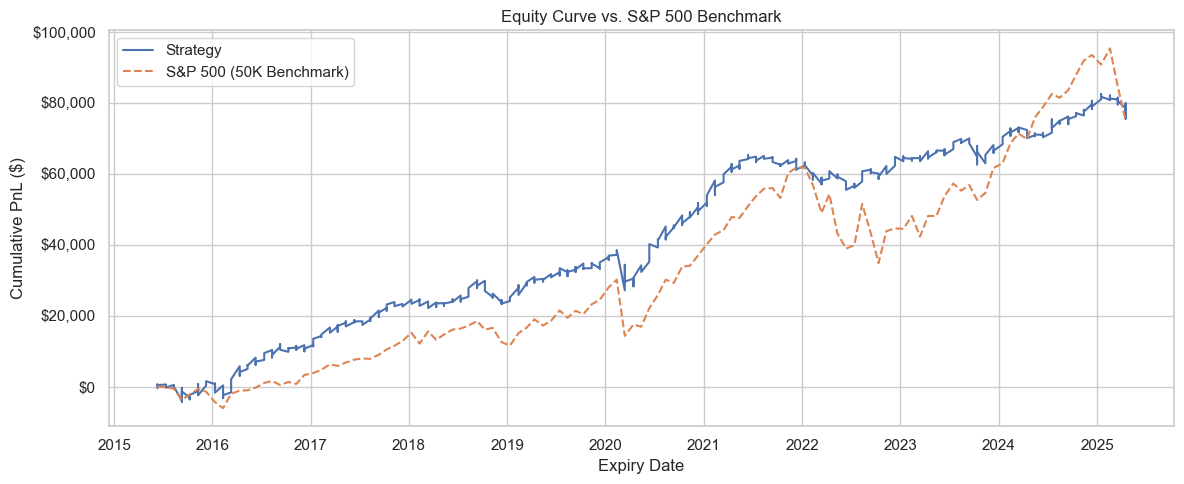

In [33]:
# Match your simulation date range
from matplotlib.ticker import StrMethodFormatter
start_date = portfolio_results["ExpiryDate"].min()
end_date = portfolio_results["ExpiryDate"].max()
portfolio_results["CumulativePnL"] = portfolio_results["PnL_Total_position"].cumsum()

spx = yf.download("^GSPC", start=start_date, end=end_date)
spx = spx["Close"].reset_index()
spx.columns = ["Date", "SP500"]
initial_value = 50000
# Merge on expiry dates (or closest forward-fill match)
spx["Date"] = pd.to_datetime(spx["Date"])
equity_curve = portfolio_results[["ExpiryDate", "CumulativePnL"]].copy()
equity_curve = equity_curve.rename(columns={"ExpiryDate": "Date"})
merged = pd.merge_asof(equity_curve.sort_values("Date"), spx.sort_values("Date"), on="Date")

merged["SP500_Return"] = merged["SP500"] / merged["SP500"].iloc[0]
merged["SP500_PnL"] = (merged["SP500_Return"] - 1) * initial_value

plt.figure(figsize=(12, 5))
plt.plot(merged["Date"], merged["CumulativePnL"], label="Strategy")
plt.plot(merged["Date"], merged["SP500_PnL"], label="S&P 500 (50K Benchmark)", linestyle="--")

plt.title("Equity Curve vs. S&P 500 Benchmark")
plt.xlabel("Expiry Date")
plt.ylabel("Cumulative PnL ($)")
plt.grid(True)
plt.legend()

# Format y-axis with commas
plt.gca().yaxis.set_major_formatter(StrMethodFormatter("${x:,.0f}"))

plt.tight_layout()
plt.show()

The histogram shows the distribution of trade-level returns as a percentage of notional per trade. The curve is sharply peaked around zero, with a pronounced right skew.

Most trades cluster between 0% and 0.25%, reflecting small, consistent gains from option premium. The long right tail represents the relatively few positions where significant gains occurred — typically from retained equity upside or large premium capture.

The thin but visible left tail suggests occasional losses, likely driven by assigned stock sold below cost or short puts on falling names. However, the core shape supports the idea that this strategy behaves like a short-volatility or yield-harvesting system: frequent small wins, with rare but manageable drawdowns.

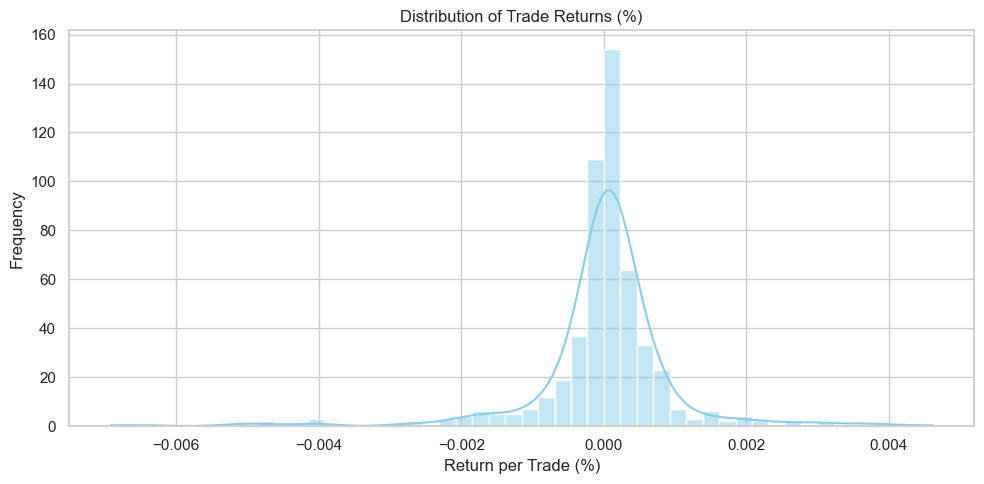

In [25]:
# === 2. Histogram of Trade Returns ===
plt.figure(figsize=(10, 5))
sns.histplot(portfolio_results["PnL_Percent"], bins=50, kde=True, color='skyblue')
plt.title("Distribution of Trade Returns (%)")
plt.xlabel("Return per Trade (%)")
plt.ylabel("Frequency")
plt.grid(True)
plt.tight_layout()
plt.show()



The bar chart shows cumulative PnL across all trades grouped by ticker. Most positions yielded modest but positive results, with a handful of names like REGN, COHR, and FOX contributing significantly to total returns.

Notably, a small number of tickers (e.g., DASH, BLDR, GNRC) generated outsized losses, suggesting occasional model failure or poor timing. These names warrant closer inspection to identify whether volatility signals were structurally unreliable, or if trades were entered during unusual market conditions.

This dispersion illustrates the benefit of a diversified, rules-based approach: while individual trades may underperform, broad application across the universe produces a net positive result.

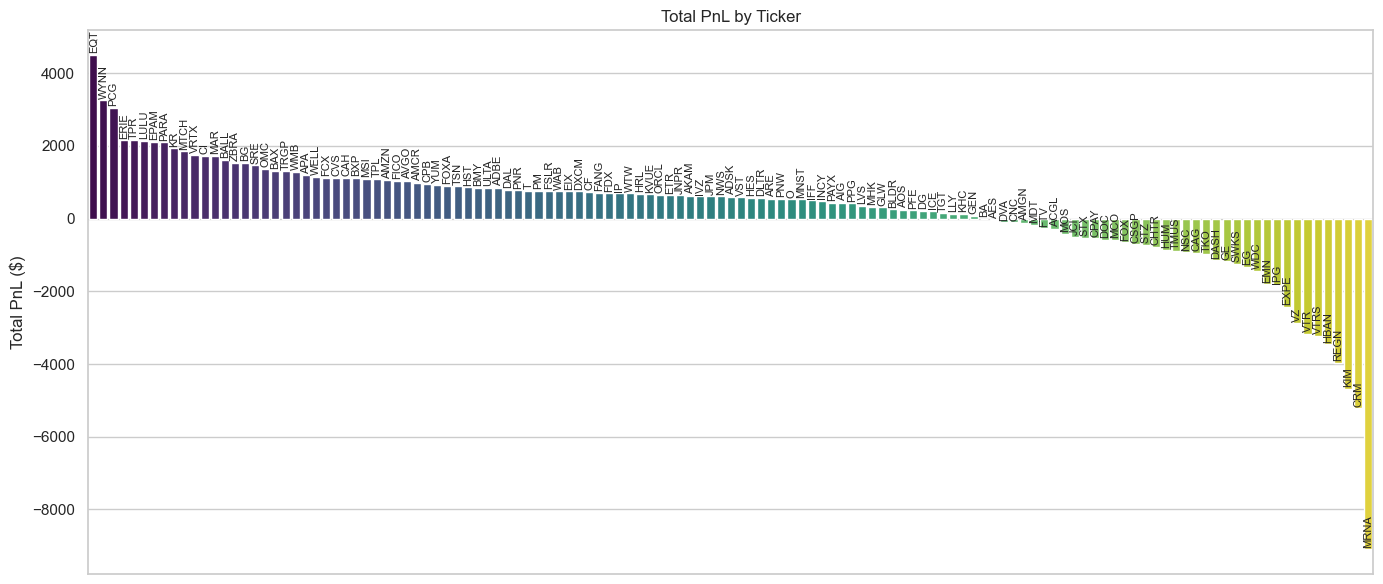

In [26]:
# === 3. PnL by Ticker (Total PnL) ===
pnl_by_ticker = (
    portfolio_results.groupby("Ticker")["PnL_Total_position"]
    .sum()
    .sort_values(ascending=False)
)

# Convert to DataFrame for Seaborn compatibility
pnl_df = pnl_by_ticker.reset_index()
pnl_df.columns = ["Ticker", "PnL_Total_position"]

plt.figure(figsize=(14, 6))
ax = sns.barplot(
    data=pnl_df,
    x="Ticker",
    y="PnL_Total_position",
    hue="Ticker",             # satisfies new requirement
    palette="viridis",
    legend=False              # we don't need the hue legend
)

# Remove x-ticks since we'll label directly
ax.set_xticks([])
ax.set_xlabel("")

# Add ticker labels on top of bars
for bar, ticker in zip(ax.patches, pnl_df["Ticker"]):
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + max(pnl_df["PnL_Total_position"]) * 0.01,
        ticker,
        ha='center',
        va='bottom',
        fontsize=8,
        rotation=90
    )

ax.set_title("Total PnL by Ticker")
ax.set_ylabel("Total PnL ($)")
plt.tight_layout()
plt.show()


## V. Prediction and Machine Learning

I trained a Random Forest classifier to predict whether a buy-write trade would be profitable based on trade-level features:
- Volatility Z-Score
- Realized volatility (forward 21-day)
- Implied Volatility proxy (premium / entry price)
- 1-month price momentum

The model achieved 67% accuracy and was especially effective at identifying profitable trades (recall = 93%). To evaluate its practical usefulness, we compared the return distribution of model-picked trades to randomly selected trades of the same size.

The results show the ML model adds value:
- **Model Avg Return:** $371 vs **Random:** $124
- **Model Sharpe:** 0.80 vs **Random:** 0.17

A two-sample t-test confirmed the difference in performance was statistically significant.

This demonstrates that ML can enhance trade selection beyond naive volatility screening.

In [41]:
from BuyWritePrediction import *
print("Features DataFrame:")
features_df = getFeatures(portfolio_results)
features_df.head(10)

Features DataFrame:


,Ticker,EntryDate,Vol_ZScore,Sector,IV_Proxy,RealizedVol,Momentum_1M,PnL_Total_position,PnL_Label
0,NWS,2015-05-12,2.333208,Communication Services,0.013308,0.115451,-0.042271,-472.978688,0
1,IP,2015-05-12,2.211255,Consumer Cyclical,0.011672,0.146848,-0.052364,82.237429,1
2,CNC,2015-05-12,2.209531,Healthcare,0.022886,0.223828,-0.036429,728.855080,1
3,YUM,2015-05-12,2.170401,Consumer Cyclical,0.014222,0.214322,0.135268,246.213609,1
4,WYNN,2015-05-12,2.163202,Consumer Cyclical,0.050487,0.398321,-0.116478,-184.201031,0
5,NWS,2015-06-11,0.993371,Communication Services,0.012179,0.254834,-0.055629,-60.536180,0
6,IP,2015-06-11,0.226068,Consumer Cyclical,0.008062,0.192070,-0.011791,-646.826460,0
7,YUM,2015-06-11,0.751161,Consumer Cyclical,0.014065,0.237713,0.015906,116.559936,1
8,WYNN,2015-06-11,-0.578080,Consumer Cyclical,0.026666,0.478174,-0.058755,596.006515,1
9,BAX,2015-06-11,3.860829,Healthcare,0.005401,0.204152,0.010186,194.880547,1


📊 Classification Report:
               precision    recall  f1-score   support

           0       0.66      0.31      0.42        62
           1       0.64      0.89      0.74        87

    accuracy                           0.64       149
   macro avg       0.65      0.60      0.58       149
weighted avg       0.65      0.64      0.61       149



C:\Users\glade\AppData\Local\Temp\ipykernel_27376\2330915773.py:32: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\glade\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


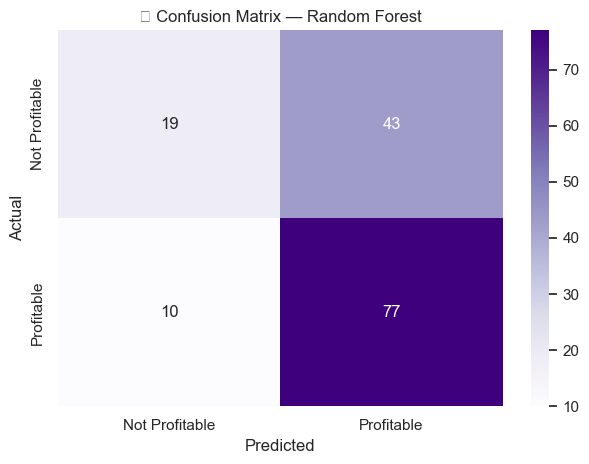

C:\Users\glade\AppData\Local\Temp\ipykernel_27376\2330915773.py:38: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\glade\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128200 (\N{CHART WITH UPWARDS TREND}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


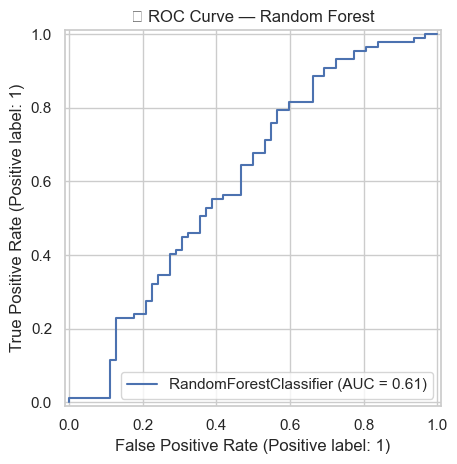

C:\Users\glade\AppData\Local\Temp\ipykernel_27376\2330915773.py:46: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\glade\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129504 (\N{BRAIN}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)


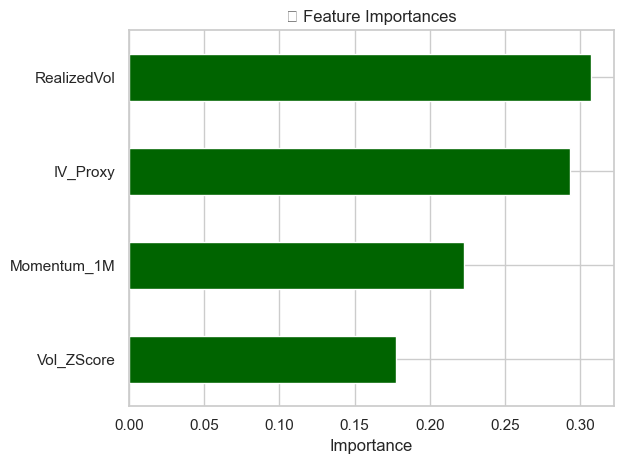

In [42]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay

# Drop missing
ml_df = features_df.dropna(subset=["Vol_ZScore", "RealizedVol", "IV_Proxy", "Momentum_1M", "PnL_Label"])

# Define features and target
X = ml_df[["Vol_ZScore", "RealizedVol", "IV_Proxy", "Momentum_1M"]]
y = ml_df["PnL_Label"]

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train random forest
rf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=42)
rf.fit(X_train, y_train)

# Predict
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:, 1]

# Evaluation
print("📊 Classification Report:\n", classification_report(y_test, y_pred))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Purples", xticklabels=["Not Profitable", "Profitable"], yticklabels=["Not Profitable", "Profitable"])
plt.title("🧠 Confusion Matrix — Random Forest")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

# ROC curve
RocCurveDisplay.from_estimator(rf, X_test, y_test)
plt.title("📈 ROC Curve — Random Forest")
plt.tight_layout()
plt.show()

# Feature importances
importances = pd.Series(rf.feature_importances_, index=X.columns)
importances.sort_values().plot(kind="barh", color="darkgreen")
plt.title("🧠 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [43]:
from scipy.stats import ttest_ind

# Predict using trained RF model
features_df["ModelPick"] = rf.predict(X)

# Extract returns
model_returns = features_df[features_df["ModelPick"] == 1]["PnL_Label"]
random_returns = features_df["PnL_Label"].sample(len(model_returns), random_state=1)

# T-test
tstat, pval = ttest_ind(model_returns, random_returns, equal_var=False)
print(f"📊 T-Test: t-stat = {tstat:.3f}, p-value = {pval:.4f}")

# Mean returns
model_avg = model_returns.mean()
random_avg = random_returns.mean()
print(f"📐 Mean Return — Model: ${model_avg:.2f}")
print(f"🎲 Mean Return — Random: ${random_avg:.2f}")

# Sharpe ratios
model_sharpe = model_returns.mean() / model_returns.std()
random_sharpe = random_returns.mean() / random_returns.std()
print(f"📐 Sharpe Ratio — Model: {model_sharpe:.2f}")
print(f"🎲 Sharpe Ratio — Random: {random_sharpe:.2f}")  

📊 T-Test: t-stat = 3.920, p-value = 0.0001
📐 Mean Return — Model: $0.74
🎲 Mean Return — Random: $0.62
📐 Sharpe Ratio — Model: 1.68
🎲 Sharpe Ratio — Random: 1.28


## VI. Optimization

The strategy was optimized using data from 2015 through 2023, with 2024 held out as a validation year. An Optuna-based hyperparameter search was conducted across three key dimensions: number of positions (`np`), option moneyness (`call_otm_pct`), and the sensitivity parameter (`theta`). Each parameter set was evaluated by simulating portfolio performance on the training set, with the Sharpe ratio of portfolio returns used as the optimization objective.

Several parameter combinations yielded strong performance on the training data, with Sharpe ratios exceeding 0.8 in many cases. However, as shown in the scatter plot below, this performance did not consistently translate to the 2024 validation period. Some of the highest Sharpe ratios in-sample were associated with significantly lower — and occasionally negative — Sharpe ratios out-of-sample.

This breakdown in generalization may be attributed to one or both of the following:
- **Overfitting**: The optimizer may have selected parameters that captured noise or idiosyncrasies in the historical window.
- **Non-stationarity**: The 2024 market environment may differ materially from the prior regime, breaking assumptions the strategy relies on.

While the results are mixed, they are also instructive. The current formulation appears sensitive to structural shifts or parameter instability, which warrants further investigation. This version of the strategy is submitted as-is, but future work will focus on walk-forward validation schemes — including rolling windows and alternating train/test periods — to reduce the risk of overfitting and better simulate real-world deployment.


In [44]:
import re
import pandas as pd
log_path = "../logs/buywrite_optimization.log"
def parse_optimization_log(log_path):
    pattern = re.compile(
        r"np=(\d+), otm=([\d.]+)%, theta=([\d.]+) \| "
        r"Train Sharpe=([-.\d]+), Train PnL=\$([-.\d,]+) \| "
        r"Val Sharpe=([-.\d]+), Val PnL=\$([-.\d,]+)"
    )
    
    rows = []
    with open(log_path, "r", encoding="utf-8") as file:
        for line in file:
            match = pattern.search(line)
            if match:
                np = int(match.group(1))
                otm = float(match.group(2))
                theta = float(match.group(3))
                train_sharpe = float(match.group(4))
                train_pnl = float(match.group(5).replace(",", ""))
                val_sharpe = float(match.group(6))
                val_pnl = float(match.group(7).replace(",", ""))
                rows.append([np, otm, theta, train_sharpe, train_pnl, val_sharpe, val_pnl])
    
    df = pd.DataFrame(rows, columns=[
        "num_positions", "call_otm_pct", "theta",
        "train_sharpe", "train_pnl",
        "val_sharpe", "val_pnl"
    ])
    
    return df

df = parse_optimization_log(log_path)
df

,num_positions,call_otm_pct,theta,train_sharpe,train_pnl,val_sharpe,val_pnl
0,10,4.14,0.433,0.60,130550.0,0.49,14252.0
1,4,1.35,0.483,0.88,72864.0,0.27,3121.0
2,10,4.87,0.018,0.07,17706.0,0.31,8068.0
3,4,3.93,0.445,0.68,63124.0,-0.14,-1902.0
4,4,8.93,0.391,0.44,44795.0,-0.14,-2227.0
5,7,3.33,0.484,0.64,100013.0,0.53,11179.0
6,9,7.51,0.022,0.18,38327.0,0.39,10675.0
7,10,5.52,0.009,0.15,34862.0,0.52,13255.0
8,7,9.32,0.160,0.27,50633.0,0.21,4932.0
9,8,2.32,0.442,0.72,120328.0,0.66,14505.0


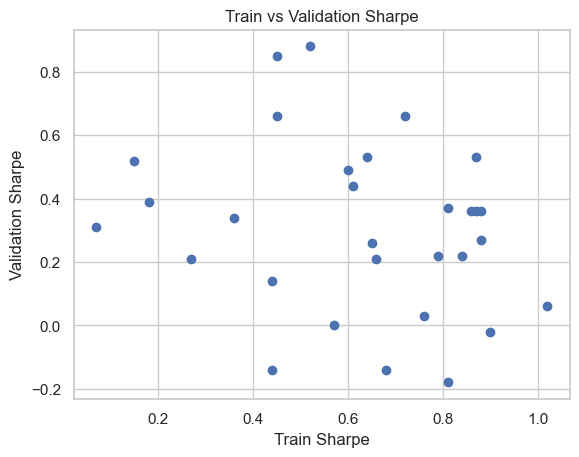

In [45]:
import matplotlib.pyplot as plt

plt.scatter(df["train_sharpe"], df["val_sharpe"])
plt.xlabel("Train Sharpe")
plt.ylabel("Validation Sharpe")
plt.title("Train vs Validation Sharpe")
plt.grid(True)
plt.show()

In [46]:
df[["train_sharpe", "val_sharpe"]].corr()

,train_sharpe,val_sharpe
train_sharpe,1.000000,-0.231716
val_sharpe,-0.231716,1.000000


## VII. Conclusion

This project explored the viability of a systematic buy-write strategy using volatility breakouts, momentum filters, and machine learning-informed trade selection. A simulation engine was developed to rotate a portfolio of S&P 500 stocks dynamically, subject to constraints on sector exposure and correlation. The optimization phase used a decade of historical data (2015–2023), with 2024 held out as a validation year.

Key observations:
- **Volatility Z-Score** is a useful feature for timing option sales.
- **Directional momentum filters** helped distinguish bullish from bearish setups.
- Sector caps and correlation constraints provided effective risk controls.
- The simulation engine consistently enforced position limits and rollover rules to mimic realistic trading.

However, the results from the optimization process revealed a key challenge: parameter sets that performed well in training often failed to generalize to the 2024 validation period. This raises two possible explanations:
- **Overfitting**: The strategy may be too closely tailored to patterns in the training data.
- **Non-stationarity**: The market regime in 2024 may have differed significantly from prior years.

While the strategy showed promise in backtests, it currently lacks out-of-sample robustness. Future work will focus on improving generalization through walk-forward validation, including rolling 8-month training / 2-month validation windows. Additional enhancements — such as more nuanced volatility features, macro overlays, or reinforcement learning for position sizing — may help strengthen the core concept.

This submission represents a working foundation, and the architecture is in place to support future research and refinement.
